In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from datetime import datetime

In [4]:
#Reading in the file
df = pd.read_csv("dataport-export_gas_oct2015-mar2016.csv")
df.tail()

,localminute,dataid,meter_value
1584818,2016-03-31 23:59:14.336743-05,2129,201726
1584819,2016-03-31 23:59:17.427165-05,2945,161232
1584820,2016-03-31 23:59:35.370782-05,9729,138146
1584821,2016-03-31 23:59:47.816286-05,5129,166488
1584822,2016-03-31 23:59:58.92308-05,484,114174


### Q1.1

In [3]:
#Each household should only have 1 meter, and thus 1 meter id per household. Finding num households
num_households = len(df["dataid"].unique())
display("The number of households is %s" %num_households)

'The number of households is 157'

In [4]:
#find malfunctioning meters
#precond: unsorted meter reading dataframe, unique dataid, correct datetime format localminutes
#postcond: count of meters that are malfunctioning

#sort according to dataid
sorted1 = df.sort_values(by=['dataid', 'localminute'])
sorted2 = sorted1.reset_index(drop=True)

In [5]:
#change index to time
timevals = []
ids = sorted2['dataid'].nunique()

form = '%Y-%m-%d %H:%M:%S'
for i in range(len(sorted2)):
    time = datetime.strptime(sorted2['localminute'][i][:18], form)  
    timevals.append(time)

sorted2.index = timevals
sorted2 = sorted2.drop(columns = 'localminute')
sorted2

,dataid,meter_value
2015-10-01 00:14:04,35,93470
2015-10-01 00:42:03,35,93470
2015-10-01 02:02:03,35,93470
2015-10-01 02:12:03,35,93470
2015-10-01 02:20:03,35,93470
...,...,...
2016-03-28 09:25:05,9982,119734
2016-03-28 11:29:04,9982,119736
2016-03-29 04:38:03,9982,119784
2016-03-30 17:46:04,9982,119852


In [6]:
#check each meter for malfunctions
#The error we are checking for is whether subsequents readings are >2 or equal. If not, it is an error
all_ids = sorted(sorted2['dataid'].unique())
all_daily_vals = pd.DataFrame()

for i in range(len(all_ids)):
    data = sorted2.loc[sorted2["dataid"] ==  all_ids[i]]
    malfunctions = [False]
    for j in range(1, len(data)):
        if data['meter_value'][j] >= data['meter_value'][j-1] + 2 or data['meter_value'][j] == data['meter_value'][j-1]:
            malfunctions.append(False)
        else:
            malfunctions.append(True)
    #Series of booleans to extract anomolous readings
    data["malfunction"] = malfunctions
    
    #create dataframe of malfunctions by day
    meter_daily = data.resample('d').max()
    all_daily_vals[int(meter_daily['dataid'][0])] = meter_daily['malfunction']

/tmp/ipykernel_471/3884915733.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["malfunction"] = malfunctions


KeyboardInterrupt: 

In [ ]:
#assume empty cells do not indicate malfunctions
all_daily_vals = all_daily_vals.fillna(0.0)

all_daily_vals = all_daily_vals.astype(bool)
all_daily_vals

In [ ]:
#check dataframe for malfunctioning meters
malfunctions = []
for i in all_ids:
    #print(all_daily_vals[i][0])
    if all_daily_vals[i].any() == True:
        malfunctions.append(i)

#print malfunctions and number of malfunctions
print ("The number of malfunctioning meters is: " + str(len(malfunctions)) + "\n")
print ("The meters that are malfunctioning are: " + str(malfunctions))

In [ ]:
#create dict of all malfunctioning time periods
malfunction_times = {}
for i in malfunctions:
    malfunction_times[i] = all_daily_vals.index[all_daily_vals[i] == True].tolist()
    
print(malfunction_times)

In [ ]:
#visualize time periods of malfunction by plotting on a graph
all_malfunctioning = pd.DataFrame()

for i in malfunctions:
    all_malfunctioning[i] = all_daily_vals[i]
#PLotting periods where they are malfunctioned
all_malfunctioning = all_malfunctioning.astype(int)
all_malfunctioning.plot(figsize=(30,10))

### Q1.2

Generate hourly readings from the raw data. Select one month from the 6-month study interval and plot the hourly readings (time-series) for that month. Hint: You will have to decide what to do if there are no readings for a certain hour.

For this question, we selected the month of October

In [ ]:
months = {'Oct':'-10-','Nov':'-11-','Dec':'-12-','Jan':'-01-','Feb':'-02-','Mar':'-03-',}
df2 = df[df['localminute'].str.contains(months['Oct'])]
df3 = df2.sort_values(by=['dataid', 'localminute'])
df3 = df3.reset_index(drop=True)

In [ ]:
#make data look nicer for each house (1 reading per hour)
times = []
ids = df3['dataid'].nunique()
#current_id = df3['dataid'][0]

form = '%Y-%m-%d %H:%M:%S'
for i in range(len(df3)):
    time = datetime.strptime(df3['localminute'][i][:18], form)  
    times.append(time)

df3.index = times
df3 = df3.drop(columns = 'localminute')
df3

In [ ]:
#run resampling by dataid
all_hourly_vals = pd.DataFrame()
running = 1
all_ids = sorted(df3['dataid'].unique())

for i in range(len(all_ids)):
    data = df3.loc[df3["dataid"] ==  all_ids[i]]
    meter_hourly = data.resample('H').max() #maybe take latest reading
    meter_hourly = meter_hourly.fillna(method='backfill')
    meter_hourly = meter_hourly.fillna(method='ffill')
    all_hourly_vals[all_ids[i]] = meter_hourly['meter_value'] - meter_hourly['meter_value'][0]
    all_hourly_vals = all_hourly_vals.fillna(method='backfill')
    all_hourly_vals = all_hourly_vals.fillna(method='ffill')
    #print(all_hourly_vals)
#all_hourly_values is a backfilled then frontfilled dataframe of hourly averaged meter values for every house in the month of October

In [ ]:
all_hourly_vals['mean'] = all_hourly_vals.mean(axis=1)
all_hourly_vals['max'] = all_hourly_vals.max(axis=1)
all_hourly_vals['min'] = all_hourly_vals.min(axis=1)
all_hourly_vals

In [ ]:
#print multiple values
house1 = all_hourly_vals[35]
house2 = all_hourly_vals[44]
house3 = all_hourly_vals[77]

fig, axs = plt.subplots(1, 3,figsize=(50,15))
axs[0].plot(all_hourly_vals.index, house1)
axs[0].set_title('House 35 Cumulative Consumption')
axs[1].plot(all_hourly_vals.index, house2, 'tab:orange')
axs[1].set_title('House 44 Cumulative Consumption')
axs[2].plot(all_hourly_vals.index, house3, 'tab:pink')
axs[2].set_title('House 77 Cumulative Consumption')

In [ ]:
# Plot mean, max and min
houseMean = all_hourly_vals["mean"]
houseMax = all_hourly_vals["max"]
houseMin = all_hourly_vals["min"]

plt.figure(figsize=(15,15))
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Cumulative Consumption', fontsize = 16)
plt.plot(all_hourly_vals.index, houseMean, label = "Mean Cumulative Consumption", linewidth = 5, color='blue')
plt.plot(all_hourly_vals.index, houseMax, label = "Max Cumulative Consumption", color='blue', alpha = 0.3)
plt.plot(all_hourly_vals.index, houseMin, label = "Min Cumulative Consumption", color='red', alpha = 0.3)
plt.fill_between(all_hourly_vals.index, houseMean, houseMax, color='blue', alpha = 0.3)
plt.fill_between(all_hourly_vals.index, houseMean, houseMin, color='red', alpha = 0.3)
plt.legend()

### Q1.3
Intuitively, we expect that gas consumption from different homes to be correlated.
For example, many homes would experience higher consumption levels in the evening
when meals are cooked. For each home, find the top five homes with which it shows
the highest correlation.

In [ ]:
#Formatting the dataframe so the time value is easier to work with
time_df = df.copy()
time_df.localminute = time_df.localminute.transform(lambda x: x[0:-3])
time_df.localminute = time_df.localminute.transform(lambda x: pd.Timestamp(x).value)

In [ ]:
#Function to get correlation
from scipy import interpolate
from scipy import stats
def get_correlation(a, b):
    #Get time series of a and b
    timea,timeb = a.localminute, b.localminute
    #Max of two start times
    start_time = max(timea.iloc[0],timeb.iloc[0])
    #Min of two end times
    end_time = min(timea.iloc[-1],timeb.iloc[-1])
    #Creating interpolation
    time_series = np.linspace(start_time, end_time, max(len(a),len(b)))
    a_interp = interpolate.interp1d(timea,a.meter_value,fill_value="extrapolate")
    b_interp = interpolate.interp1d(timeb,b.meter_value,fill_value="extrapolate")
    a_new = a_interp(time_series)
    b_new = b_interp(time_series)
    #Get correlation
    return stats.pearsonr(a_new,b_new)

In [ ]:
#Correlation "matrix" dataframe
households = df["dataid"].unique()
correlation_df = pd.DataFrame(columns=households, index = households)
for i in range(num_households):
    base_household = time_df[time_df.dataid == households[i]]
    for j in range(i+1,num_households):
        comparison_household = time_df[time_df.dataid == households[j]]
        corr, _ = get_correlation(base_household,comparison_household)
        correlation_df.loc[households[i],households[j]] = corr
        correlation_df.loc[households[j],households[i]] = corr

In [ ]:
#Typecast to float for comparison
#Get top 5 correlations
correlation_df = correlation_df.astype("float64")
top5_correlations = pd.DataFrame(index=households, columns=[1,2,3,4,5])
for household in households:
    top5_correlations.loc[household] = correlation_df.nlargest(5,household).index.to_list()

In [ ]:
top5_correlations.to_csv("cor.csv")
top5_correlations

In [ ]:
top5_correlations.loc[4874]

### Q3

Additional analysis: </br>
#### Todo:
Make a standard time series </br>
        Interpolate all series into standard time series </br>
        Use tslearn to do kmeans </br>
        analyse clusters </br>

In [3]:
def find_spikes(x,trailing=5):
    spikes = []
    for i in range(trailing,len(x)-trailing):
        trailing_arr = x[i-trailing:i+trailing]
        mean = np.mean(trailing_arr)
        std = np.std(trailing_arr)
        if x[i] > mean + 1.5*std:
            spikes.append(i)
    return spikes

In [16]:
spike_timings = {}
households = df["dataid"].unique().tolist()
for household in households:
    filtered = df[df.dataid == household]
    filtered = filtered.sort_values("localminute")
    x = dfResampled2.loc[household]
    spike = find_spikes(x)
    if spike:
        spike_timings[household] = spike

In [17]:
spike_timings

{8156: [1730],
 9639: [1968, 1979, 1980],
 7030: [468, 1625, 1650, 1685, 1724, 1731],
 2449: [1740, 1743],
 9134: [468],
 7117: [384, 1625, 1626, 1628],
 2335: [1648, 1649, 1662, 1727],
 1556: [1632, 1648, 1649, 1664, 1666, 1681, 1685, 1697, 1706],
 3544: [1626, 1633, 1706, 1722],
 1185: [468],
 3134: [1637, 1638, 1645, 1659, 1660, 1674, 1678, 1682, 1683, 1743],
 9982: [1715, 1716],
 7989: [1128]}

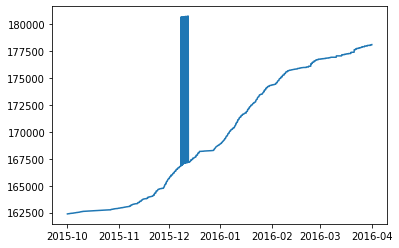

In [43]:
plt.plot(dfResampled2.columns, dfResampled2.loc[3134])
plt.show()

In [39]:
#sort by dataid & timestamp
dfSorted = df.sort_values(by=['dataid', 'localminute'])
dfSorted = dfSorted.reset_index(drop=True)
all_ids = sorted(dfSorted['dataid'].unique())
#function to identify meter IDs with duplicate readings
def checkDuplicates(df, id):
    data = df.loc[df['dataid'] == id]
    boolList = list(data.localminute.duplicated())
    for i in boolList:
        if(i == True):
            return True
    return False
# print(checkDuplicates(dfSorted, 35))   #check specific meter ID

#Visualize all meter IDs with duplicates using above function
hasDuplicates = []
for i in all_ids:
    if(checkDuplicates(dfSorted, i) == True):
        hasDuplicates.append(i)
# print("Meter IDs with duplicate readings: ", hasDuplicates)
# print("Indexes of these meter IDs: ", all_ids.index(4031), all_ids.index(8890))
#create an overall df with resampled localminute in hours
startDate = datetime(2015, 10, 1)
endDate = datetime(2016, 4, 1)
hours = pd.date_range(startDate, endDate, freq='H', closed='left')   #hourly freq

#overall df
dfResampled = pd.DataFrame()
dfResampled['localminute'] = hours

#concat cols of meter readings to overall df
for j in range(len(all_ids)):
    data = dfSorted.loc[dfSorted["dataid"] ==  all_ids[j]]   #select rows of specified meter ID
    data = data.drop_duplicates(subset=['localminute'])   #drop duplicate readings
    
    form = '%Y-%m-%d %H:%M:%S'
    timeList = []
    for i in range(len(data)):
        time = datetime.strptime(data.localminute.values[i][:19], form)   #extract datetime up to seconds
        timeList.append(time)
    data.index = timeList
    data = data.drop(columns = 'localminute')    
    meter_hourly = data.resample('H').max()   #max reading for each resampled hour
    #meter_hourly = meter_hourly.fillna(method='ffill')   #forward fill NaN cells   
    
    #create new df containing just 1 col of interpolated readings for that meter ID
    dfTemp = pd.DataFrame()
    dfTemp[all_ids[j]] = list(meter_hourly.meter_value.values)   
    dfResampled = pd.concat([dfResampled, dfTemp], axis=1)   #concat new col of interpolated readings to overall df
    
dfResampled = dfResampled.fillna(method='ffill')   #forward fill all NaN values    
dfResampled2 = dfResampled.copy()
#transpose the df
dfResampled2 = dfResampled2.T

#set first row as df header
newHeader = dfResampled2.iloc[0] 
dfResampled2 = dfResampled2.iloc[1:] 
dfResampled2.columns = newHeader
dfResampled2

localminute,2015-10-01 00:00:00,2015-10-01 01:00:00,2015-10-01 02:00:00,2015-10-01 03:00:00,2015-10-01 04:00:00,2015-10-01 05:00:00,2015-10-01 06:00:00,2015-10-01 07:00:00,2015-10-01 08:00:00,2015-10-01 09:00:00,...,2016-03-31 14:00:00,2016-03-31 15:00:00,2016-03-31 16:00:00,2016-03-31 17:00:00,2016-03-31 18:00:00,2016-03-31 19:00:00,2016-03-31 20:00:00,2016-03-31 21:00:00,2016-03-31 22:00:00,2016-03-31 23:00:00
35,93470.0,93470.0,93470.0,93470.0,93470.0,93470.0,93472.0,93472.0,93472.0,93472.0,...,104670.0,104672.0,104672.0,104672.0,104672.0,104682.0,104682.0,104684.0,104690.0,104692.0
44,165674.0,165674.0,165674.0,165684.0,165684.0,165686.0,165686.0,165686.0,165686.0,165688.0,...,175070.0,175070.0,175070.0,175070.0,175070.0,175070.0,175070.0,175070.0,175070.0,175070.0
77,58832.0,58832.0,58832.0,58832.0,58832.0,58834.0,58840.0,58840.0,58846.0,58846.0,...,64642.0,64646.0,64646.0,64646.0,64646.0,64652.0,64652.0,64652.0,64652.0,64652.0
94,116642.0,116644.0,116644.0,116644.0,116644.0,116644.0,116644.0,116646.0,116646.0,116646.0,...,140356.0,140356.0,140356.0,140358.0,140358.0,140358.0,140358.0,140358.0,140358.0,140358.0
114,128294.0,128296.0,128296.0,128296.0,128296.0,128296.0,128298.0,128298.0,128298.0,128308.0,...,145298.0,145298.0,145298.0,145298.0,145298.0,145298.0,145298.0,145298.0,145298.0,145298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9729,122186.0,122186.0,122186.0,122188.0,122188.0,122188.0,122188.0,122190.0,122196.0,122196.0,...,138136.0,138142.0,138142.0,138144.0,138144.0,138144.0,138144.0,138144.0,138146.0,138146.0
9766,158512.0,158512.0,158512.0,158512.0,158512.0,158512.0,158512.0,158512.0,158512.0,158512.0,...,179902.0,179902.0,179902.0,179902.0,179902.0,179902.0,179902.0,179902.0,179902.0,179902.0
9849,33632.0,33632.0,33632.0,33632.0,33632.0,33638.0,33638.0,33638.0,33638.0,33638.0,...,39292.0,39292.0,39292.0,39292.0,39292.0,39292.0,39292.0,39292.0,39292.0,39292.0
9956,95860.0,95860.0,95860.0,95860.0,95860.0,95862.0,95862.0,95868.0,95870.0,95870.0,...,107042.0,107042.0,107042.0,107042.0,107042.0,107042.0,107042.0,107042.0,107042.0,107042.0


In [40]:
df3 = dfResampled2.copy()
for index, row in dfResampled2.iterrows():
    minim = row.min()
    row = row - minim
    maxim = row.max()
    row = row/maxim
    df3.loc[index] = row
df3

localminute,2015-10-01 00:00:00,2015-10-01 01:00:00,2015-10-01 02:00:00,2015-10-01 03:00:00,2015-10-01 04:00:00,2015-10-01 05:00:00,2015-10-01 06:00:00,2015-10-01 07:00:00,2015-10-01 08:00:00,2015-10-01 09:00:00,...,2016-03-31 14:00:00,2016-03-31 15:00:00,2016-03-31 16:00:00,2016-03-31 17:00:00,2016-03-31 18:00:00,2016-03-31 19:00:00,2016-03-31 20:00:00,2016-03-31 21:00:00,2016-03-31 22:00:00,2016-03-31 23:00:00
35,0.0,0.0,0.0,0.0,0.0,0.0,0.000178,0.000178,0.000178,0.000178,...,0.99804,0.998218,0.998218,0.998218,0.998218,0.999109,0.999109,0.999287,0.999822,1.0
44,0.0,0.0,0.0,0.001064,0.001064,0.001277,0.001277,0.001277,0.001277,0.00149,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
77,0.0,0.0,0.0,0.0,0.0,0.000344,0.001375,0.001375,0.002405,0.002405,...,0.998282,0.998969,0.998969,0.998969,0.998969,1.0,1.0,1.0,1.0,1.0
94,0.0,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000169,0.000169,0.000169,...,0.999916,0.999916,0.999916,1.0,1.0,1.0,1.0,1.0,1.0,1.0
114,0.0,0.000118,0.000118,0.000118,0.000118,0.000118,0.000235,0.000235,0.000235,0.000823,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9729,0.0,0.0,0.0,0.000125,0.000125,0.000125,0.000125,0.000251,0.000627,0.000627,...,0.999373,0.999749,0.999749,0.999875,0.999875,0.999875,0.999875,0.999875,1.0,1.0
9766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9849,0.0,0.0,0.0,0.0,0.0,0.00106,0.00106,0.00106,0.00106,0.00106,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9956,0.0,0.0,0.0,0.0,0.0,0.000179,0.000179,0.000715,0.000894,0.000894,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [42]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
X = df3.values.tolist()
X = np.array(X, dtype='float64')
X = to_time_series_dataset(X)
labels_bis = km_bis.fit_predict(X)
labels_bis

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1])

In [55]:
cluster0 = np.where(labels_bis == 0)
cluster1 = np.where(labels_bis == 1)
cluster0df = df3.iloc[cluster0]
cluster1df = df3.iloc[cluster1]

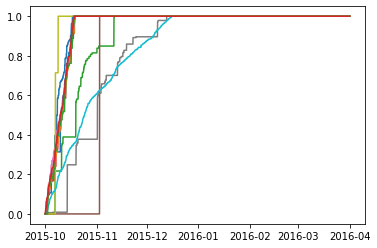

In [56]:
for index, row in cluster0df.iterrows():
    plt.plot(dfResampled2.columns, row.values)
plt.show()

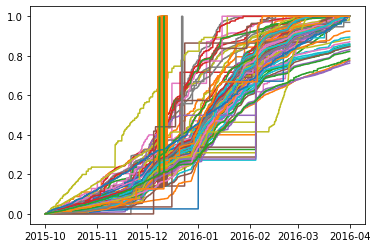

In [57]:
for index, row in cluster1df.iterrows():
    plt.plot(dfResampled2.columns, row.values)
plt.show()